## RMM all-in-one PFBS gradient-descent-like algorithm
This code focuses on the core of the RMM, a joint PFBS/gradient descent algorithm on the residues. 
This part is then alternated with a barycentric pole relocation part to update the poles

This program implements in Python 3 :
      - the simplest Vector Fitting algorithm (no complex conjugation for real case, no QR, no Relaxation, no othrogonal basis, etc.)
      - adds a polynomial entire part to the rational fit, of arbitrary order poly_order
      - Codes a PFBS algorithm for pole filtering

NOTE : author is Pablo DUCRU, for any inquires please e-mail at  *** p_ducru@mit.edu ***

In [1]:
## Import necessary packages
import matplotlib.pyplot as plt
import importlib
import numpy as np
from rmm import utils

In [2]:
## Import Python package for data management
#import pandas as pd

In [3]:
## Importing Python packages for plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


### Rational Functions Space
The space of functions we are learning in is that of proper rational fraction of degree zero (poles + offset)

In [4]:
## Generic rational fractions with an offset and an entire part.
# > The entire part is specified by the set of coefficients.
# > If no coefficients are provided (the empty set), the rational function is build with a simple offset, the default value of which is zero.
def rational_function(z, poles, residues, offset=0, poly_coeff=()):
    if poly_coeff == ():
        poly_order = 0
        ## print("The rational_function function was not given an entire polynomial part to build.")
    else:
        poly_order = poly_coeff.shape[0]
    return  sum(residues[n]/(z-poles[n]) for n in range(poles.size)) + offset + sum(poly_coeff[n]*z**(n+1) for n in range(poly_order))

In [5]:
## build the square root of the rho_k weights for the LS system :: linear heteroscedastic case
def build_rho_k(z_train, Y_train = ()):
    number_train_points = z_train.size
    rho = np.zeros([number_train_points], dtype=np.complex)
    for k in range(number_train_points):
        rho[k] =  1.0/(number_train_points) # CHANGE HERE FOR HETEROSKEDASTIC *(np.sqrt(np.linalg.norm(Y_train[k])))))  ## * (np.linalg.norm(Y_train[k])) ))) ## for linear heteroscedastic case, add: *np.linalg.norm(Y_train[k]))
    return rho

## Valling Vlad Module
Import training data

In [26]:
from rmm import utils as utils
x, data_1, data_2, true_value_1, true_value_2, poles, residues = utils.load_data("training_data/run1")
data_1 = data_1.view('float')
true_value_1 = true_value_1.view('float')

In [7]:
true_value_1.shape

(250,)

In [8]:
true_value_2.shape

(125,)

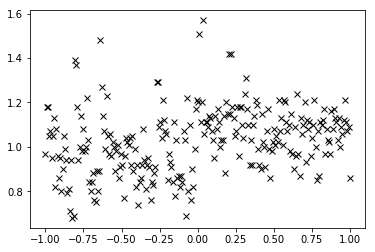

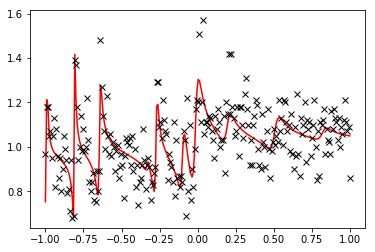

In [9]:
## Ploting the noisy training points upon the real data
fig_training_points = plt.figure()
#plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(x, data_1, 'x k', label = 'Y_train')
plt.show()

fig_training_points = plt.figure()
plt.plot(x, true_value_1, 'r', label='Y_true')
plt.plot(x, data_1, 'x k', label = 'Y_train')
plt.show()

In [10]:
z_train = x
#Y_train = data_1
# OLD 1-D Y_train = Y_train.reshape((len(Y_train),1))
Y_train = np.transpose(np.vstack((data_1,data_1))) # new 2-D
#Y_true = true_value_1
# OLD 1-D Y_true = Y_true.reshape((len(Y_true),1))
Y_true = np.transpose(np.vstack((true_value_1,true_value_1))) # NEW 2D
true_poles = poles
true_residues = residues[:,0].reshape((len(residues),1))
number_true_poles = len(true_poles)
number_train_points = len(z_train)
true_offset = np.array([1])

rho = build_rho_k(z_train, Y_train = ())

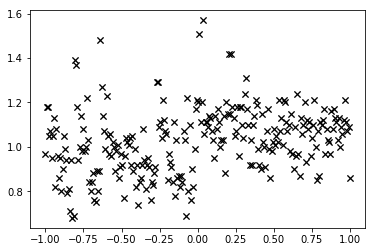

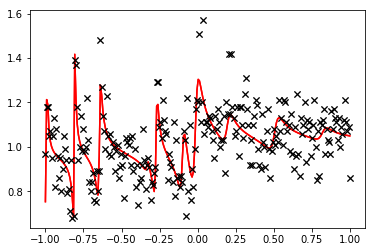

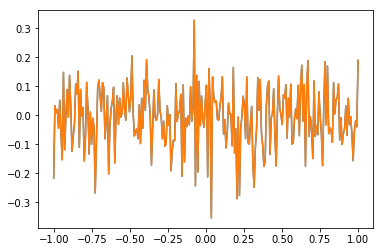

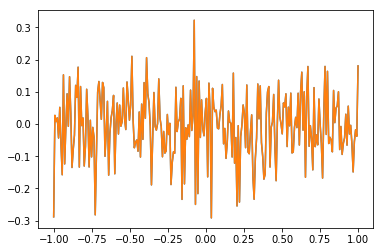

In [11]:
## Ploting the noisy training points upon the real data
fig_training_points = plt.figure()
#plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(z_train, Y_train, 'x k', label = 'Y_train')
plt.show()

fig_training_points = plt.figure()
plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(z_train, Y_train, 'x k', label = 'Y_train')
plt.show()

fig_training_points_diff = plt.figure()
plt.plot(z_train, Y_true - Y_train)
plt.show()


fig_training_points_rel_diff = plt.figure()
plt.plot(z_train, (Y_true - Y_train)/Y_true)
plt.show()

In [12]:
## Proximal operator for L1-L2 group regularization
def prox_lam(A,lam):
    return A*max(0,1-lam/np.linalg.norm(A))

In [13]:
def Tikhonov_gradient_Rn(Z,Y,rho,poles,R,mu,Delta_fun):
    gradient = np.zeros([len(poles),len(Y[0])], dtype=complex )
    
    for n, pole in enumerate(poles):
        gradient[n] = 2*mu*R[n]/Delta_fun(Z,rho,pole)
    return gradient

In [14]:
def SK_gradient_Rn(Z,Y,rho,poles,R,C,r):
    gradient = np.zeros([len(poles),len(Y[0])] , dtype=complex )
    for n, pole in enumerate(poles):
        for k,z in enumerate(Z):
            Diff_k = utils.rational_function_at_z(z,poles,R,C) - utils.rational_function_at_z(z,poles,r,1)*Y[k]
            gradient[n] += (rho[k]/np.conj(z - pole))*Diff_k
    return 2*gradient

In [15]:
def learning_rate_Rn(Z,rho,poles,mu,Delta_fun):
    gamma_Rn = np.zeros(len(poles), dtype=complex )
    for n, pole in enumerate(poles):
        temp = 0*1j
        for k in range(len(Z)):
            temp += rho[k]/(np.abs(Z[k]-pole)**2)
        temp = 2*temp + 2*mu/Delta_fun(Z,rho,pole)
        gamma_Rn[n] = 1/temp
    return gamma_Rn

In [16]:
def SK_gradient_C(Z,Y,rho,poles,R,C,r):
    gradient_C = 0*1j
    for k,z in enumerate(Z):
        Diff_k = utils.rational_function_at_z(z,poles,R,C) - utils.rational_function_at_z(z,poles,r,1)*Y[k]
        gradient_C += rho[k]*Diff_k
    return 2*gradient_C

In [17]:
def learning_rate_C(Z,rho):
    temp = 0*1j
    for k in range(len(Z)):
        temp += rho[k]
    temp = 2*temp 
    gamma_C = 1/temp
    return gamma_C

In [18]:
def SK_gradient_rn(Z,Y,rho,poles,R,C,r):
    gradient = np.zeros([len(poles),len(Y[0])] , dtype=complex )
    for n in range(len(poles)):
        for k in range(len(Z)):
            Diff_k = utils.rational_function_at_z(Z[k],poles,R,C) - utils.rational_function_at_z(Z[k],poles,r,1)*Y[k]
            gradient[n] += (rho[k]/np.conj(Z[k] - poles[n]))*Y[k].conj().T@Diff_k
    return -2*gradient

In [19]:
def learning_rate_rn(Z,Y,rho,poles):
    gamma_rn = np.zeros(len(poles), dtype=complex )
    for n in range(len(poles)): 
        temp = 0*1j
        temp_matrix = 0*1j*Y[0].conj().T@Y[0]
        for k in range(len(Z)):
            temp_matrix += rho[k]/(np.abs(Z[k]-poles[n])**2)*(np.tensordot(Y[k].conj().T,Y[k],0))
        eigenvalues, eigenvectors = np.linalg.eig(temp_matrix)
        temp = 2*max(eigenvalues)
        gamma_rn[n] = 1/temp
    return gamma_rn

In [20]:
Y = Y_train
Y 

array([[0.97, 0.97],
       [1.18, 1.18],
       [1.18, 1.18],
       [1.05, 1.05],
       [1.07, 1.07],
       [0.95, 0.95],
       [1.05, 1.05],
       [1.13, 1.13],
       [0.82, 0.82],
       [1.08, 1.08],
       [0.96, 0.96],
       [0.86, 0.86],
       [0.95, 0.95],
       [0.8 , 0.8 ],
       [0.9 , 0.9 ],
       [1.05, 1.05],
       [0.99, 0.99],
       [0.94, 0.94],
       [0.79, 0.79],
       [0.81, 0.81],
       [0.71, 0.71],
       [0.94, 0.94],
       [0.68, 0.68],
       [0.69, 0.69],
       [1.39, 1.39],
       [1.37, 1.37],
       [1.18, 1.18],
       [0.94, 0.94],
       [1.  , 1.  ],
       [1.14, 1.14],
       [0.98, 0.98],
       [1.08, 1.08],
       [0.98, 0.98],
       [1.  , 1.  ],
       [1.22, 1.22],
       [1.03, 1.03],
       [0.84, 0.84],
       [0.8 , 0.8 ],
       [0.84, 0.84],
       [0.88, 0.88],
       [0.76, 0.76],
       [0.75, 0.75],
       [0.89, 0.89],
       [0.8 , 0.8 ],
       [0.89, 0.89],
       [1.48, 1.48],
       [1.27, 1.27],
       [1.14,

In [21]:
(np.tensordot(Y[0].conj().T, Y[0],0))

array([[0.9409, 0.9409],
       [0.9409, 0.9409]])

In [22]:
def delta_min_distance(z_train, pole, Y_train = ()):
    min_distance = min(np.abs(z_train - pole))
    return min_distance

def delta_min_distance_sq(z_train,pole, Y_train = ()):
    value = delta_min_distance(z_train,pole)
    return value**2

def delta_learning_rate(z_train, pole, Y_train=()):
    gamma_R_p_inv = 0*1j
    for k in range(z_train.size):
        gamma_R_p_inv += 2*rho[k]/np.abs(z_train[k] - pole)**2
    return (1/gamma_R_p_inv)**0.5

def delta_learning_rate_sq(z_train, pole, Y_train=()):
    value = delta_learning_rate(z_train, pole, Y_train)
    return value**2

def delta_average_pole(z_train, pole, Y_train = ()):
    temp = 0*1j
    for k in range(z_train.size):
        temp += rho[k]/np.abs(z_train[k] - pole)
    return 1/temp

def delta_average_sq_pole(z_train, pole, Y_train = ()):
    temp = 0*1j
    for k in range(z_train.size):
        temp += (rho[k]/np.abs(z_train[k] - pole))**2
    Delta = 1/temp
    return Delta 

def delta_average_pole_sq(z_train, pole, Y_train = ()):
    value = delta_average_pole(z_train, pole, Y_train)
    return value**2

def delta_inv_im_real(z_train, pole, Y_train = ()):
    Delta = 1/np.real(pole) + 1/np.imag(pole)
    return Delta 

def delta_inv_im_real(z_train, pole, Y_train = ()):
    value = delta_inv_im_real(z_train, pole, Y_train)
    return value**2

In [23]:
## This function takes N_iter steps of the regularized residues solving
# d2, mu is the regularization for the Tikhonov, and d1, lam(bda) if for the Lasso term.
def RMM_PFBS_iterations(Z,Y,rho,poles,R,C,r,mu,lam,d_1,d_2, N_iter = 100): 
    R_next = R
    C_next = C
    r_next = r
    for ell in range(N_iter):
        print('RMM_PFBS_iteration = ', ell)
        gamma_Rn = learning_rate_Rn(Z,rho,poles,mu,d_2)
        print('gamma_Rn = ', gamma_Rn)
        gradient_Rn = SK_gradient_Rn(Z,Y,rho,poles,R,C,r) + Tikhonov_gradient_Rn(Z,Y,rho,poles,R,mu,d_2)
        print('gradient_Rn = ', gradient_Rn)
        gamma_C = learning_rate_C(Z,rho)
        print('gamma_C = ', gamma_C)
        gradient_C = SK_gradient_C(Z,Y,rho,poles,R,C,r)
        print('gradient_C = ', gradient_C)
        gamma_rn = learning_rate_rn(Z,Y,rho,poles)
        print('gamma_rn = ', gamma_rn)
        gradient_rn = SK_gradient_rn(Z,Y,rho,poles,R,C,r)
        print('gradient_rn = ', gradient_rn)        
        
        print('take one RMM PBFS step')
        for n,pole in enumerate(poles):
            R_next[n] = prox_lam(R[n] - gamma_Rn[n]*gradient_Rn[n], lam/d_2(Z,rho,pole))
            print('R_next = ', R_next)
            print('r[n] = ', r[n])
            print('gamma_rn[n]*gradient_rn[n] = ', gamma_rn[n]*gradient_rn[n])
            r_next[n] = r[n] - gamma_rn[n]*gradient_rn[n]
            print('r_next = ', r_next)
        print('C = ', C)
        print('gamma_C*gradient_C = ', gamma_C*gradient_C)
        C_next = C - gamma_C*gradient_C
        print('C_next = ', C_next)
        # update the residues to re-take a PFBS step
        R = R_next
        C = C_next
        r = r_next
    return R_next , C_next , r_next

In [24]:
## This function takes N_RMM_iter steps (pole relocations) of the all-in-one RMM algorithm, with N_PFBS_iter for each regularized residues solving
# d2, mu is the regularization for the Tikhonov, and d1, lam(bda) if for the Lasso term.
def RMM_algorithm(Z,Y,rho, mu,lam, d_1,d_2, N_RMM_iter = 1, N_PFBS_iter = 100 , *arguments ):
    # Look at the dimension of the data being learned
    dim_residues = Y[0].size
    number_train_points = len(Z)
    ## Initialize the poles
    if arguments == ():
        print("The RMM_algorithm function was given no initial poles guess information, it will produce a default of array of floor(number_train_points/3) poles") 
        number_poles = int(np.floor( number_train_points/ 3))
        if (np.amax(np.imag(Z)) - np.amin(np.imag(Z))) == 0: ## only real training data
            print("The training points are only along the real axis, and the initial guesses are generated accordingly with a shift")
            poles = np.linspace(np.amin(np.real(Z))+1/(10*(np.amax(np.real(Z)) - np.amin(np.real(Z)))),np.amax(np.real(Z)) + 1/(10*(np.amin(np.real(Z))-np.amax(np.real(Z)))) , number_poles) + 1j*np.linspace(np.amin(np.imag(Z)),np.amax(np.imag(Z)), number_poles)
        elif (np.amax(np.real(Z)) - np.amin(np.real(Z)) ) == 0:
            print("The training points are exactly along the imaginary axis, and the initial guesses are generated accordingly with a shift")
            poles = np.linspace(np.amin(np.real(Z)),np.amax(np.real(Z)) , number_poles) + 1j*np.linspace(np.amin(np.imag(Z)) + 1/(10*(np.amax(np.imag(Z)) - np.amin(np.imag(Z)))) ,np.amax(np.imag(Z)) - 1/(10*(np.amax(np.imag(Z)) - np.amin(np.imag(Z)))), number_poles)
        else:
            print("The training points are generally complex, and the initial guesses are accordingly generated along the complex diagonal with a shift")
            poles = np.linspace(np.amin(np.real(Z))+1/(10*(np.amax(np.real(Z))-np.amin(np.real(Z)))),np.amax(np.real(Z)) - 1/(10*(np.amax(np.real(Z)) - np.amin(np.real(Z)))) , number_poles) + 1j*np.linspace(np.amin(np.imag(Z)) + 1/(10*(np.amax(np.imag(Z)) - np.amin(np.imag(Z)))), np.amax(np.imag(Z)) -  1/(10*(np.amax(np.imag(Z)) - np.amin(np.imag(Z)))) , number_poles)
    for arg in arguments:
        if type(arg) == np.ndarray: ## was given an initial guess as argument
            print(" The RMM_algorithm was provided an array of initial guess poles")
            poles = arg
            number_poles = len(poles)
        elif type(arg) == int: ## was given a number of poles without any initial guess
            print("The RMM_algorithm was provided a number of poles to learn and is generating a default initial guess")
            number_poles = arg
            if (np.amax(np.imag(Z)) - np.amin(np.imag(Z))) == 0: ## only real training data
                print("The training points are only along the real axis, and the initial guesses are generated accordingly with a shift")
                poles = np.linspace(np.amin(np.real(Z))+1/(10*(np.amax(np.real(Z)) - np.amin(np.real(Z)))),np.amax(np.real(Z)) + 1/(10*(np.amin(np.real(Z))-np.amax(np.real(Z)))) , number_poles) + 1j*np.linspace(np.amin(np.imag(Z)),np.amax(np.imag(Z)), number_poles)
            elif (np.amax(np.real(Z)) - np.amin(np.real(Z)) ) == 0:
                print("The training points are exactly along the imaginary axis, and the initial guesses are generated accordingly with a shift")
                poles = np.linspace(np.amin(np.real(Z)),np.amax(np.real(Z)) , number_poles) + 1j*np.linspace(np.amin(np.imag(Z)) + 1/(10*(np.amax(np.imag(Z)) - np.amin(np.imag(Z)))) ,np.amax(np.imag(Z)) - 1/(10*(np.amax(np.imag(Z)) - np.amin(np.imag(Z)))), number_poles)
            else:
                print("The training points are generally complex, and the initial guesses are accordingly generated along the complex diagonal with a shift")
                poles = np.linspace(np.amin(np.real(Z))+1/(10*(np.amax(np.real(Z))-np.amin(np.real(Z)))),np.amax(np.real(Z)) - 1/(10*(np.amax(np.real(Z)) - np.amin(np.real(Z)))) , number_poles) + 1j*np.linspace(np.amin(np.imag(Z)) + 1/(10*(np.amax(np.imag(Z)) - np.amin(np.imag(Z)))), np.amax(np.imag(Z)) -  1/(10*(np.amax(np.imag(Z)) - np.amin(np.imag(Z)))) , number_poles)
    ## Initialize the residues
    print("The RMM algorithm initializes the residues at zero by default (early stopping regularization), add feature to solve el L2 system")
    R = np.zeros([number_poles, dim_residues])
    C = np.zeros([dim_residues])
    r = np.zeros([number_poles])
    mu_next = 0
    lam_next = 0
    for t in range(N_RMM_iter):
        ## Residues Solving
        R_next , C_next , r_next = RMM_PFBS_iterations(Z,Y,rho,poles,R,C,r,mu_next,lam_next,d_1,d_2, N_PFBS_iter)
        ## Pole Filtering
        filtered_indexes = [np.array_equal(R_next, [0,0]) for residue in R_next]
        filtered_R = R[filtered_indexes]
        filtered_poles = poles[filtered_indexes]
        filtered_barycentric_residues = r_next[filtered_indexes]
        ## Pole Relocation (barycentric pole relocation)
        P = np.diag(filtered_poles) - np.tensordot(filtered_barycentric_residues,np.ones([filtered_barycentric_residues.size], dtype=np.complex),0)
        ## Solve the spectral problem & relocate poles
        relocated_poles , useless_eigenvectors = np.linalg.eig(P)
        ## Loop back on the poles and residues
        poles = relocated_poles
        R = filtered_R
        C = C_next
        r = filtered_barycentric_residues
        ## update mu and lam parameters (if needed)
        if t == (N_RMM_iter-2) : #This clause means it is pure VF until the last one
            mu_next = mu
            lam_next = lam
    ## extract final poles and residues
    RMM_poles = poles
    RMM_residues = R
    return RMM_poles, RMM_residues

In [25]:
mu = 0
lam = 0
d_1 = delta_min_distance
d_2 = delta_min_distance
RMM_poles, RMM_residues = RMM_algorithm(z_train, Y_train ,rho, mu,lam, d_1,d_2, 2, 10 )

The RMM_algorithm function was given no initial poles guess information, it will produce a default of array of floor(number_train_points/3) poles
The training points are only along the real axis, and the initial guesses are generated accordingly with a shift
The RMM algorithm initializes the residues at zero by default (early stopping regularization), add feature to solve el L2 system
RMM_PFBS_iteration =  0
gamma_Rn =  [3.46897150e-04+0.j 9.34743169e-05+0.j 2.42843624e-07+0.j
 1.12125721e-04+0.j 3.73612274e-04+0.j 6.53936911e-04+0.j
 8.11800665e-04+0.j 7.67455066e-04+0.j 5.43606132e-04+0.j
 2.53205364e-04+0.j 4.17364496e-05+0.j 1.46049246e-05+0.j
 1.85285033e-04+0.j 4.68561999e-04+0.j 7.22416091e-04+0.j
 8.19059691e-04+0.j 7.09780829e-04+0.j 4.49753400e-04+0.j
 1.69756540e-04+0.j 1.00453136e-05+0.j 5.03903593e-05+0.j
 2.70635462e-04+0.j 5.60586220e-04+0.j 7.74708565e-04+0.j
 8.05224817e-04+0.j 6.36778273e-04+0.j 3.54210208e-04+0.j
 9.94371430e-05+0.j 2.69849345e-08+0.j 1.05660502e-04+

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


ValueError: setting an array element with a sequence.

In [ ]:
gamma_C

In [ ]:
np.tensordot(Y_train[0].conj().T,Y_train[0],1)

In [ ]:
testo = np.array([10, 20, 30]) 
testo = 1 - testo
for k, tes in enumerate(testo):
    print('k = ', k)
    print('tes = ', tes)
min(np.abs(testo))

#### Results benchmarking and analysis


VF algorithm results

In [ ]:
VF_poles, VF_residues, VF_poly_coeff, VF_offset, VF_residual, barycentric_residues = VF_algorithm(z_train, Y_train, 30, 0, 25) ## add VF_poly_coeff when poly_order not zero 

In [ ]:
## Function that measures how well did the VF algorithm the true poles. 
def VF_finds_true_poles_accuracy(true_poles, VF_poles):
    performance = 0
    for pole in true_poles:
        performance += min([np.abs(pole-pole_vf) for pole_vf in VF_poles])
    return performance/len(true_poles)

In [ ]:
perf = VF_finds_true_poles_accuracy(true_poles, VF_poles)
perf

In [ ]:
## VF results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_VF = np.zeros([z_train.size, dim_residues] , dtype=complex) ## VF solution
for k in range(z_train.size):
    Y_VF[k] = rational_function(z_train[k], VF_poles, VF_residues, VF_offset) # add when poly_order not zero : VF_poly_coeff)

Plotting Vector Fitting results

In [ ]:
fig_train_vs_VF = plt.figure()
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF')
#plt.plot(z_train, Y_true, 'r', label='Y_true')

fig_train_vs_VF = plt.figure()
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF')
plt.plot(z_train, Y_true, 'r', label='Y_true')

#plt.ylim(-20,20)
plt.xlabel('z')
plt.ylabel('F(z)')
plot_title = 'VF fit'
plt.title(plot_title)
plt.legend()
#plt.show()
plt.rcParams['axes.facecolor'] = '0.98'


In [ ]:
VF_poles

## RMM Regularizations for different Delta options

We here define a pole-filtering regularization, as explained in the equations of article here:
https://www.overleaf.com/read/vjrwkmvhdzdg

In [ ]:
## Proximal operator for L1-L2 group regularization
def prox_λ(A,λ):
    return A*max(0,1-λ/np.linalg.norm(A))

In [ ]:
def delta_min_distance(z_train, poles, Y_train = ()):
    min_distances_z_p = np.zeros(len(poles), dtype=complex )
    for p in range(poles.size):
        min_distances_z_p[p] = np.abs(poles[p] - z_train[0])
        for k in range(z_train.size):
            if np.abs(poles[p] - z_train[k]) < min_distances_z_p[p] :
                min_distances_z_p[p] = np.abs(poles[p] - z_train[k])
    return min_distances_z_p

def delta_min_distance_sq(z_train,poles, Y_train = ()):
    value = delta_min_distance(z_train,poles)
    return value**2

def delta_learning_rate(z_train, poles, Y_train=()):
    Delta = np.zeros(len(poles) , dtype=complex )
    sqrt_weights_rho = build_square_weights_rho_k(z_train) 
    for p in range(poles.size):
        gamma_R_p_inv = 0
        for k in range(z_train.size):
            gamma_R_p_inv += 2*(sqrt_weights_rho[k]/np.abs(z_train[k] - poles[p]) )**2
        Delta[p] = (1/gamma_R_p_inv)**0.5
    return Delta 

def delta_learning_rate_sq(z_train, poles, Y_train=()):
    value = delta_learning_rate(z_train, poles, Y_train)
    return value**2

def delta_average_pole(z_train, poles, Y_train = ()):
    Delta = np.zeros(len(poles) , dtype=complex )
    rho = build_square_weights_rho_k(z_train)**2 
    for p in range(poles.size):
        temp = 0
        for k in range(z_train.size):
            temp += rho[k]/np.abs(z_train[k] - poles[p])
        Delta[p] = 1/temp
    return Delta

def delta_average_sq_pole(z_train, poles, Y_train = ()):
    Delta = np.zeros(len(poles) , dtype=complex )
    rho = build_square_weights_rho_k(z_train)**2 
    for p in range(poles.size):
        temp = 0
        for k in range(z_train.size):
            temp += (rho[k]/np.abs(z_train[k] - poles[p]))**2
        Delta[p] = 1/temp
    return Delta 

def delta_average_pole_sq(z_train, poles, Y_train = ()):
    value = delta_average_pole(z_train, poles, Y_train)
    return value**2


def delta_inv_im_real(z_train, poles, Y_train = ()):
    Delta = np.zeros(len(poles) , dtype=complex )
    for pole in poles:
        Delta[p] = 1/np.real(pole) + 1/np.imag(pole)
    return Delta 


def delta_inv_im_real(z_train, poles, Y_train = ()):
    value = delta_inv_im_real(z_train, poles, Y_train)
    return value**2

In [ ]:
def RMM_pole_filtering(delta_function,z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the least distances from z_k to poles:
    Δ = delta_function(z_train, poles, Y_train)
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ/Δ[p])
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

#### Results of the Pole Filtering Regularization

Pole Filtering trumps L1-L2 group regularization

In [ ]:
regularizing_functions = [delta_min_distance, delta_min_distance_sq,delta_average_pole,delta_average_sq_pole,delta_average_pole_sq,delta_learning_rate,delta_learning_rate_sq,delta_inv_im_real]
lambdas = [1e-9, 1e-12, 5*1e-8, 1e-8, 1e-8,1e-8,1e-8,1e-8]
Y_output = []
for jj, regularizer in enumerate(regularizing_functions):
    RMM_residues, RMM_offset , γ , RMM_Condition_number, RMM_iter_num = RMM_pole_filtering(delta_min_distance,z_train, Y_train, VF_poles , lambdas[jj], 0.0)
    ## Pole filtered results
    z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
    dim_residues = Y_train[0].size
    Y_RMM = np.zeros([z_train.size, dim_residues] , dtype=complex) 
    for k in range(z_train.size):
        Y_RMM[k] = rational_function(z_train[k], VF_poles, RMM_residues, RMM_offset )
    Y_output.append(Y_RMM)

In [ ]:
## Plotting PFBS results v/s VF results v/s the true model data (log-space data is in absolute value)
labels = ["Y_PF", "Y_PF2",  "Y_Rational", "Y_2_Rational","Y_Rational2", "Y_RMM", "Y_RMM2","Y_inv"]
plt.figure()
plot_title = 'Different regularizations'
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF' )
#plt.plot(z_train, Y_PFBS, 'g', label='Y_PFBS')
for ii, label in enumerate(labels):
    plt.plot(z_train, Y_output[ii],label = label)
plt.plot(z_train, Y_true, 'r', label='Y_true' )
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('F(z)')
plt.title(plot_title)
plt.legend()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

plt.figure()
plot_title = 'Different regularizations (semilog)'
plt.semilogy(z_train, np.abs(Y_train), 'x k', label='Y_train' )
plt.semilogy(z_train, np.abs(Y_VF), 'b', label='Y_VF' )
#plt.semilogy(z_train, np.abs(Y_PFBS), 'g', label='Y_PFBS')
for ii, label in enumerate(labels):
    plt.semilogy(z_train, Y_output[ii],label = label)
plt.semilogy(z_train, np.abs(Y_true), 'r', label='Y_true' )
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('|F(z)| (log scale)')
plt.title(plot_title)
plt.legend()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

plt.figure()
plot_title = 'Relative difference to true'
plt.semilogy(z_train, np.abs((Y_true - Y_VF)/Y_true), 'b', label='Y_VF' )
#plt.semilogy(z_train, np.abs((Y_true - Y_PFBS)/Y_true), 'g', label='Y_PFBS')
for ii, label in enumerate(labels):
    plt.semilogy(z_train, np.abs((Y_true - Y_output[ii])/Y_true),label = label)
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('|Y_true(z_k) - F(z_k)|/|Y_true(z_k)|')
plt.title(plot_title)
plt.legend()
#plt.show()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

## Remaining (to be done)

There are only 3 things remaining at this stage: 
> • benchmark the VF alroghtm: in particular its ability to catch all the right poles if provided with (noisy) data. Because in the end we are supposing that VF would if given the right amount of poles. What if this is not the case?

> • Test which pole filtering regularization works best.

> • Test pole v/s residues regularization for final result with the right nuber of poles. 

> • It is likely that all the results depend on the form of the noise. Choose the right noise. 

> • Test RMM v/s brute force VF on time and performance. 

> • Implement and test the validity of the adaptive learning rates $\gamma_n = \frac{1}{2\sum_k \frac{\rho_k}{|z_k - p_n|^2}}$
 
 > • Propose, implement, and test relationship between noise and lambda $\lambda \sim \sigma$ with $\sigma \sim \sum_k \rho_k \left\| F(z_k) - Y_k \right\|_2^2$ 
 
 > • Test of real-case problem: oxygen-16 (good example because ENDF does not give the resonance parameters, so we can only "blindly" fit the date, and observe wether we find what R-matrix theory finds. If these are neutral-particle chanels, the fundamental assumption that we are searching for rational functions is valid, and then we are indeed testing the poerformance of the Rational Matrix Machine on noisy date for a real case. If it finds the exact solution, we could claim we have a "New Machine Learning Algorithm Learns Nuclear Physics", which is sexy enought, certainly for ICML, but if the algorithm is very good, why not in Nature Communciations. 

## Feature selection | Residues finding
Comparing the performance of Tichonov regularization, residues dampening regularization (with squares?), and direct least-squares